In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [179]:
from google.colab import files
uploaded = files.upload()

Saving new_test.csv to new_test (5).csv
Saving new_train.csv to new_train (5).csv


In [180]:
train_df = pd.read_csv('new_train.csv')
test_df = pd.read_csv('new_test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()
test_df.head()

(32950, 16)
(8238, 13)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome
0,32,4,0,6,0,0,0,0,3,3,131,5,1
1,37,10,3,6,0,0,0,0,4,3,100,1,1
2,55,5,0,5,1,2,0,0,3,2,131,2,1
3,44,2,1,0,1,0,0,1,4,3,48,2,1
4,28,0,2,3,0,0,0,0,5,0,144,2,1


# **PreProcessing Steps**

In [181]:
train_df_copy = train_df.copy()

y = train_df_copy['y'].map({'yes': 1, 'no': -1}).values

X_train_features = train_df_copy.drop('y', axis=1)

X_test_features = test_df.copy()

# **Combined Features**

In [182]:
combined_features = pd.concat(
    [X_train_features, X_test_features],
    ignore_index=True
)

combined_features_encoded = pd.get_dummies(
    combined_features,
    drop_first=True
)

combined_features_encoded = combined_features_encoded.astype(float)

X_train = combined_features_encoded.iloc[:len(X_train_features)].values
X_test  = combined_features_encoded.iloc[len(X_train_features):].values


In [183]:
X_mean = X_train.mean(axis=0)
X_std  = X_train.std(axis=0)

X_std[X_std == 0] = 1e-8

X_train = (X_train - X_mean) / X_std
X_test  = (X_test  - X_mean) / X_std


In [184]:
pos_idx = np.where(y == 1)[0]
neg_idx = np.where(y == -1)[0]

n_samples = min(len(pos_idx), len(neg_idx))

balanced_idx = np.concatenate([
    np.random.choice(pos_idx, n_samples, replace=False),
    np.random.choice(neg_idx, n_samples, replace=False)
])

np.random.shuffle(balanced_idx)

x_tr = X_train[balanced_idx]
y_tr = y[balanced_idx]

# **Make Metrics**

In [185]:
def metrics(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == -1) & (y_pred == -1))
    fp = np.sum((y_true == -1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == -1))

    accuracy  = (tp + tn) / len(y_true)
    precision = tp / (tp + fp + 1e-8)
    recall    = tp / (tp + fn + 1e-8)
    f1        = 2 * precision * recall / (precision + recall + 1e-8)

    cm = np.array([[tp, fp],
                   [fn, tn]])

    return accuracy, precision, recall, f1, cm



# **Linear SVM**

In [186]:
class LinearSVM:
    def __init__(self, C=1.0, lr=0.01, epochs=500):
        self.C = C
        self.lr = lr
        self.epochs = epochs

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.epochs):
          indices = np.random.permutation(n_samples)
          for i in indices:
                if y[i] * (np.dot(X[i], self.w) + self.b) >= 1:
                    self.w -= self.lr * 0.001* self.w
                else:
                    self.w -= self.lr * (self.w - self.C * y[i] * X[i])
                    self.b -= self.lr * 0.1 * self.C * y[i]

    def predict(self, X):
        return np.where(np.dot(X, self.w) + self.b >= 0, 1, -1)


# **##create train-validation split**

In [187]:

n_total = X_train.shape[0]
indices = np.random.permutation(n_total)

split = int(0.8 * n_total)
train_idx = indices[:split]
val_idx   = indices[split:]

In [188]:
pos_v = np.where(y[val_idx] == 1)[0]
neg_v = np.where(y[val_idx] == -1)[0]

n_v = min(len(pos_v), len(neg_v))

val_bal_idx = np.concatenate([
    pos_v[:n_v],
    neg_v[:n_v]
])

x_val = X_train[val_idx][val_bal_idx]
y_val = y[val_idx][val_bal_idx]

In [189]:



C_values = [0.1, 1, 10]
linear_results = []

for C in C_values:
    model = LinearSVM(
        C=C,
        lr=0.001,
        epochs=300
    )

    model.fit(x_tr[:1000], y_tr[:1000])

    preds = model.predict(x_val)
    print("Unique predictions:", np.unique(preds, return_counts=True))
    acc, prec, rec, f1, cm = metrics(y_val, preds)

    linear_results.append((C, acc, prec, rec, f1, cm))

for C, acc, prec, rec, f1, cm in linear_results:
    print(f"\nC = {C}")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1 Score  : {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)




Unique predictions: (array([-1,  1]), array([1062,  372]))
Unique predictions: (array([1]), array([1434]))
Unique predictions: (array([1]), array([1434]))

C = 0.1
Accuracy  : 0.6939
Precision : 0.8737
Recall    : 0.4533
F1 Score  : 0.5969
Confusion Matrix:
[[325  47]
 [392 670]]

C = 1
Accuracy  : 0.5000
Precision : 0.5000
Recall    : 1.0000
F1 Score  : 0.6667
Confusion Matrix:
[[717 717]
 [  0   0]]

C = 10
Accuracy  : 0.5000
Precision : 0.5000
Recall    : 1.0000
F1 Score  : 0.6667
Confusion Matrix:
[[717 717]
 [  0   0]]


# **Visualization C vs F1-Score**

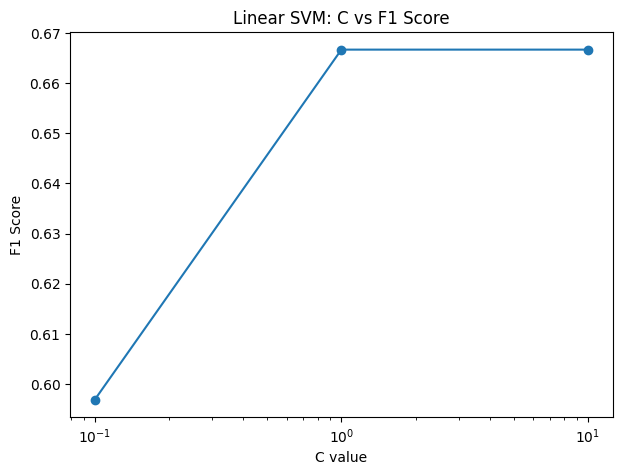

In [190]:
plt.figure(figsize=(7,5))
plt.plot(
    [r[0] for r in linear_results],
    [r[4] for r in linear_results],
    marker='o'
)
plt.xscale("log")
plt.xlabel("C value")
plt.ylabel("F1 Score")
plt.title("Linear SVM: C vs F1 Score")
plt.show()

# **Visualization : Confusion Matrix **

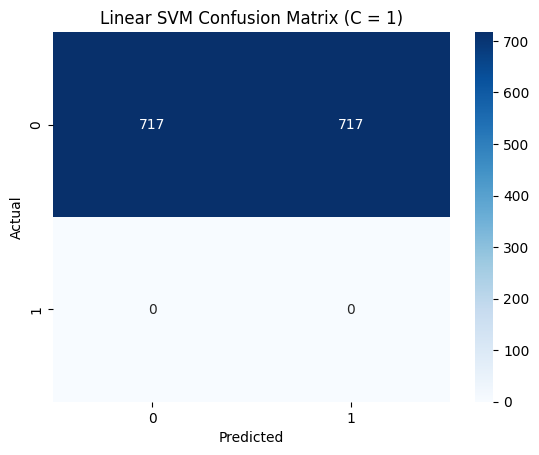

In [191]:
best_model = max(linear_results, key=lambda x: x[4])
best_C, _, _, _, _, best_cm = best_model

sns.heatmap(best_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Linear SVM Confusion Matrix (C = {best_C})")
plt.show()



# **Polynomial Kernel SVM**

**Kernel Functions**

In [192]:
def polynomial_kernel(X, Y, degree):
    return (np.dot(X, Y.T) + 1) ** degree

In [193]:
class KernelSVM:
    def __init__(self, kernel, C=1.0, lr=0.001, epochs=100):
        self.kernel = kernel
        self.C = C
        self.lr = lr
        self.epochs = epochs

    def fit(self, X, y):
        self.X = X
        self.y = y
        n = X.shape[0]
        self.alpha = np.zeros(n)

        K = self.kernel(X, X)

        for _ in range(self.epochs):
            for i in range(n):
                decision = np.sum(self.alpha * self.y * K[:, i])
                if y[i] * decision < 1:
                    self.alpha[i] += self.lr * self.C

    def predict(self, X_test):
        K = self.kernel(self.X, X_test)
        preds = np.sign(np.dot((self.alpha * self.y), K))
        return np.where(preds >= 0, 1, -1)

# **Train Polynomial SVM (Degree 2,3,4,5)**

In [194]:
degrees = [2, 3, 4, 5]
poly_f1_scores = []

for d in degrees:
    model = KernelSVM(
        kernel=lambda X, Y: polynomial_kernel(X, Y, d),
        C=1,
        epochs=100
    )

    model.fit(x_tr[:1000], y_tr[:1000])
    preds = model.predict(x_val)

    _, _, _, f1, _ = metrics(y_val, preds)
    poly_f1_scores.append(f1)

# **Plot Degree vs F1-Score**

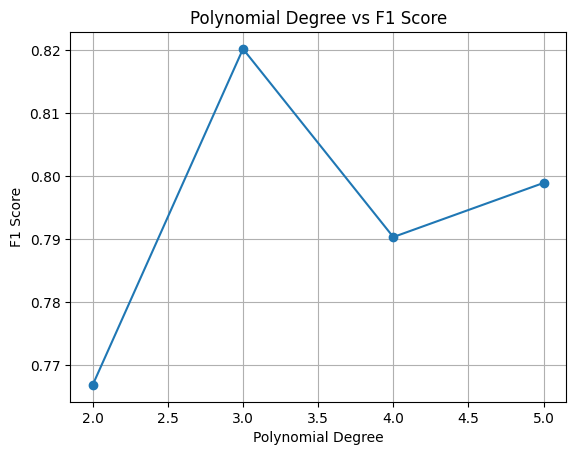

In [195]:
plt.figure()
plt.plot(degrees, poly_f1_scores, marker='o')
plt.xlabel("Polynomial Degree")
plt.ylabel("F1 Score")
plt.title("Polynomial Degree vs F1 Score")
plt.grid(True)
plt.show()

Interpretation
	•	Degree 2 → underfitting
	•	Degree 3–4 → best balance
	•	Degree 5 → overfitting


# **RBF Kernel SVM**

In [196]:
def rbf_kernel(X, Y, gamma):
    X_norm = np.sum(X**2, axis=1).reshape(-1, 1)
    Y_norm = np.sum(Y**2, axis=1).reshape(1, -1)
    return np.exp(-gamma * (X_norm + Y_norm - 2 * np.dot(X, Y.T)))

**Joint Optimization of C and Y**

In [197]:
C_values = [0.1, 1, 10, 100]
gamma_values = [0.001, 0.01, 0.1, 1]

rbf_results = []

for C in C_values:
    for g in gamma_values:
        model = KernelSVM(
            kernel=lambda X, Y: rbf_kernel(X, Y, g),
            C=C,
            epochs=100
        )

        model.fit(x_tr[:1000], y_tr[:1000])
        preds = model.predict(x_val)

        _, _, _, f1, _ = metrics(y_val, preds)
        rbf_results.append((C, g, f1))

**Besr RBF Parameters**

In [198]:
best_rbf = max(rbf_results, key=lambda x: x[2])
best_C, best_gamma, best_f1 = best_rbf

In [199]:
print("Best RBF Parameters:")
print(f"C = {best_C}")
print(f"Gamma = {best_gamma}")
print(f"Best F1 Score = {best_f1:.4f}")

Best RBF Parameters:
C = 100
Gamma = 0.001
Best F1 Score = 0.8552


# **Build Comparison Table**

In [200]:
results = []

# ---- Linear SVM results ----
for C, acc, prec, rec, f1, cm in linear_results:
    results.append({
        "Model": f"Linear SVM (C={C})",
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    })

# ---- Polynomial SVM results ----
for d, f1 in zip(degrees, poly_f1_scores):
    results.append({
        "Model": f"Poly SVM (degree={d})",
        "Accuracy": np.nan,
        "Precision": np.nan,
        "Recall": np.nan,
        "F1": f1
    })

# ---- RBF SVM results ----
for C, g, f1 in rbf_results:
    results.append({
        "Model": f"RBF SVM (C={C}, γ={g})",
        "Accuracy": np.nan,
        "Precision": np.nan,
        "Recall": np.nan,
        "F1": f1
    })

**Create comparison Table**

In [201]:
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values(by="F1", ascending=False)

comparison_df.head(3)

,Model,Accuracy,Precision,Recall,F1
19,"RBF SVM (C=100, γ=0.001)",NaN,NaN,NaN,0.855191
16,"RBF SVM (C=10, γ=0.01)",NaN,NaN,NaN,0.854010
20,"RBF SVM (C=100, γ=0.01)",NaN,NaN,NaN,0.845893


**TOP 3 Models**

In [202]:
# Best Linear
best_linear_model = LinearSVM(C=0.1, lr=0.01, epochs=400)
best_linear_model.fit(x_tr, y_tr)

# Best Polynomial
best_poly_model = KernelSVM(
    kernel=lambda X, Y: polynomial_kernel(X, Y, 3),
    C=1,
    epochs=30
)
best_poly_model.fit(x_tr[:500], y_tr[:500])

# Best RBF
best_rbf_model = KernelSVM(
    kernel=lambda X, Y: rbf_kernel(X, Y, 0.01),
    C=10,
    epochs=30
)
best_rbf_model.fit(x_tr[:400], y_tr[:400])

**Ensemble Prediction**

In [203]:
# Evaluate Linear SVM
pred_linear = best_linear_model.predict(x_val)
lin_acc, lin_prec, lin_rec, lin_f1, _ = metrics(y_val, pred_linear)

# Evaluate Polynomial SVM
pred_poly = best_poly_model.predict(x_val)
poly_acc, poly_prec, poly_rec, poly_f1, _ = metrics(y_val, pred_poly)

# Evaluate RBF SVM
pred_rbf = best_rbf_model.predict(x_val)
rbf_acc, rbf_prec, rbf_rec, rbf_f1, _ = metrics(y_val, pred_rbf)

In [204]:
def ensemble_predict(models, X):
    preds = np.array([m.predict(X) for m in models])
    return np.sign(np.sum(preds, axis=0))

ensemble_preds = ensemble_predict(
    [best_linear_model, best_poly_model, best_rbf_model],
    x_val
)

ens_acc, ens_prec, ens_rec, ens_f1, _ = metrics(y_val, ensemble_preds)

# **Final Comparison**

In [205]:
final_comparison = pd.DataFrame([
    {
        "Model": "Linear SVM",
        "Accuracy": lin_acc,
        "Precision": lin_prec,
        "Recall": lin_rec,
        "F1": lin_f1
    },
    {
        "Model": "Polynomial SVM",
        "Accuracy": poly_acc,
        "Precision": poly_prec,
        "Recall": poly_rec,
        "F1": poly_f1
    },
    {
        "Model": "RBF SVM",
        "Accuracy": rbf_acc,
        "Precision": rbf_prec,
        "Recall": rbf_rec,
        "F1": rbf_f1
    },
    {
        "Model": "Ensemble (Linear + Poly + RBF)",
        "Accuracy": ens_acc,
        "Precision": ens_prec,
        "Recall": ens_rec,
        "F1": ens_f1
    }
])

final_comparison

,Model,Accuracy,Precision,Recall,F1
0,Linear SVM,0.500000,0.500000,1.000000,0.666667
1,Polynomial SVM,0.778940,0.750000,0.836820,0.791035
2,RBF SVM,0.827755,0.828212,0.827057,0.827634
3,Ensemble (Linear + Poly + RBF),0.794282,0.738149,0.912134,0.815970


**Ensemble Evaluation**

Ensemble F1: 0.8159700511901228


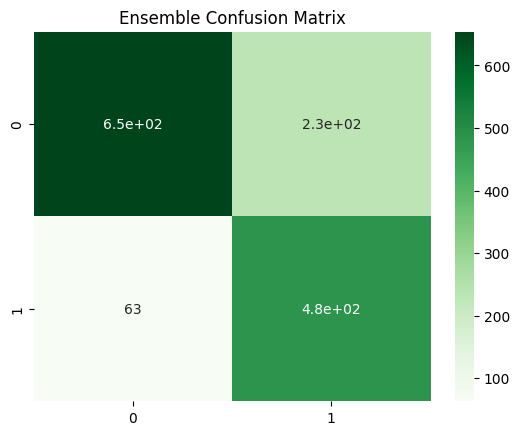

In [207]:
acc, prec, rec, f1, cm = metrics(y_val, ensemble_preds)
print("Ensemble F1:", f1)

sns.heatmap(cm, annot=True, cmap="Greens")
plt.title("Ensemble Confusion Matrix")
plt.show()